In [4]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

# Bagian Baru

In [ ]:
# !unrar x "/content/drive/MyDrive/cnn od/sign language.rar" "/content/drive/MyDrive/cnn od/"

In [ ]:
import os
import cv2
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from collections import Counter


In [ ]:
# Path to your dataset directory
dataset_dir = '/content/drive/MyDrive/Skripsi/2020/Arya/jari/jari'

In [ ]:
# Fungsi untuk memuat gambar dan anotasi
def load_dataset(dataset_dir):
    images = []
    annotations = []
    classes_set = set()

    # Memuat gambar dan anotasi XML yang sesuai
    image_dir = os.path.join(dataset_dir, 'images')
    label_dir = os.path.join(dataset_dir, 'labels')

    for filename in os.listdir(image_dir):
        if filename.endswith('.jpg'):
            img_path = os.path.join(image_dir, filename)
            annotation_path = os.path.join(label_dir, os.path.splitext(filename)[0] + '.xml')

            # Membaca gambar
            image = cv2.imread(img_path)
            height, width, _ = image.shape

            # parsing anotasi XML
            tree = ET.parse(annotation_path)
            root = tree.getroot()

            # Mengambil ukuran gambar dari XML
            image_size = root.find('size')
            img_width = int(image_size.find('width').text)
            img_height = int(image_size.find('height').text)

            # Mengubah ukuran gambar jika diperlukan (opsional)
            #image = cv2.resize(image, (320, 320))

            # Mengambil koordinat bounding box dan label
            for obj in root.findall('object'):
                obj_name = obj.find('name').text
                classes_set.add(obj_name)  # Menambahkan kelas ke set kelas
                bbox = obj.find('bndbox')
                xmin = int(bbox.find('xmin').text) / img_width * 320
                xmax = int(bbox.find('xmax').text) / img_width * 320
                ymin = int(bbox.find('ymin').text) / img_height * 320
                ymax = int(bbox.find('ymax').text) / img_height * 320

                annotations.append({
                    'image_path': img_path,
                    'label': obj_name,
                    'bbox': [xmin, ymin, xmax, ymax],
                })

            images.append(image)

    classes_list = sorted(list(classes_set))  # Mengubah set menjadi daftar kelas yang terurut
    num_classes = len(classes_list)

    return images, annotations, num_classes, classes_list

In [ ]:
# Fungsi untuk menampilkan gambar dengan bounding box
def display_images_with_bboxes(images, annotations, classes_list, num_samples=5):
    plt.figure(figsize=(15, 15))
    for i in range(num_samples):
        image = images[i]
        ann = annotations[i]
        bbox = ann['bbox']
        label = ann['label']
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.gca().add_patch(plt.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1],
                                          edgecolor='red', facecolor='none', linewidth=2))
        plt.title(classes_list[label])
    plt.show()

In [ ]:
# Memuat dataset
images, annotations, num_classes, classes_list = load_dataset(dataset_dir)


In [ ]:
# Mengubah label menjadi nilai numerik
class_to_index = {cls: idx for idx, cls in enumerate(classes_list)}
for annotation in annotations:
    annotation['label'] = class_to_index[annotation['label']]

In [ ]:
# Menghitung jumlah setiap kelas dalam dataset
label_counts = Counter([ann['label'] for ann in annotations])

# Menampilkan statistik jumlah dataset berdasarkan kelas
print("\nStatistik jumlah dataset berdasarkan kelas:")
for cls, count in label_counts.items():
    print(f"{classes_list[cls]}: {count} gambar")


Statistik jumlah dataset berdasarkan kelas:
D: 76 gambar
R: 52 gambar
Q: 68 gambar
A: 71 gambar
O: 58 gambar
Y: 62 gambar
J: 61 gambar
N: 75 gambar
H: 63 gambar
W: 49 gambar
G: 64 gambar
T: 51 gambar
B: 49 gambar
P: 53 gambar
M: 68 gambar
I: 64 gambar
X: 51 gambar
E: 88 gambar
Z: 49 gambar
C: 66 gambar
S: 73 gambar
K: 50 gambar
F: 93 gambar
L: 58 gambar
U: 36 gambar
V: 45 gambar


In [ ]:
# Mempersiapkan data untuk pelatihan
X = np.array(images)
y_bbox = np.array([ann['bbox'] for ann in annotations])
y_class = np.array([ann['label'] for ann in annotations])

In [ ]:
# Membagi data menjadi set pelatihan dan validasi
X_train, X_val, y_bbox_train, y_bbox_val, y_class_train, y_class_val, annotations_train, annotations_val = train_test_split(
    X, y_bbox, y_class, annotations, test_size=0.2, random_state=42)

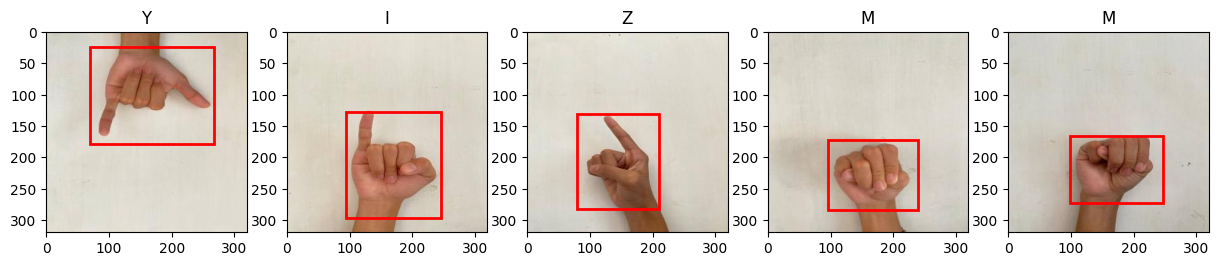

In [ ]:
# Menampilkan beberapa gambar dengan bounding box
display_images_with_bboxes(X_train, annotations_train, classes_list, num_samples=5)

In [ ]:
# Menampilkan informasi dataset
print(f"Jumlah gambar: {len(X)}")
print(f"Jumlah kelas: {num_classes}")
print(f"Dimensi gambar: {X.shape[1:]}")
print(f"Label kelas: {classes_list}")


Jumlah gambar: 1593
Jumlah kelas: 26
Dimensi gambar: (320, 320, 3)
Label kelas: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [ ]:
# Mendefinisikan model MobileNet
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(320, 320, 3))


17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
# Menambahkan layer custom untuk regresi bounding box dan prediksi kelas
x = base_model.output
x = GlobalAveragePooling2D()(x)


In [ ]:
from tensorflow.keras.layers import Dropout

#Menambahkan Dropout ke layer yang sesuai
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)  # Contoh: dropout 50%

In [ ]:
# Output untuk regresi bounding box
bbox_output = Dense(4, activation='linear', name='bbox_output')(x)


In [ ]:
# Output untuk prediksi kelas
class_output = Dense(num_classes, activation='softmax', name='class_output')(x)


In [ ]:
# Menggabungkan output
model = Model(inputs=base_model.input, outputs=[bbox_output, class_output])

In [ ]:
# Menampilkan bentuk model
model.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 320, 320, 3)]        0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 160, 160, 32)         864       ['input_2[0][0]']             
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 160, 160, 32)         128       ['conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 conv1_relu (ReLU)           (None, 160, 160, 32)         0         ['conv1_bn[0][0]']      

In [ ]:
# Mengompilasi model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss={'bbox_output': 'mean_squared_error', 'class_output': 'sparse_categorical_crossentropy'},
              metrics={'bbox_output': 'mse', 'class_output': 'accuracy'})

In [ ]:
#from tensorflow.keras.callbacks import EarlyStopping

# Definisikan Early Stopping
#early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

from tensorflow.keras.callbacks import ModelCheckpoint

# Path untuk menyimpan model
checkpoint_path = '/content/drive/MyDrive/Skripsi/2020/Arya/jari/model_checkpoint2.h5'

# Callback untuk menyimpan model ketika val_accuracy meningkat
checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_class_output_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=False,
    save_freq='epoch'
)

# Melatih model dengan ModelCheckpoint
history = model.fit(
    X_train, {'bbox_output': y_bbox_train, 'class_output': y_class_train},
    validation_data=(X_val, {'bbox_output': y_bbox_val, 'class_output': y_class_val}),
    epochs=150,
    batch_size=32,
    callbacks=[checkpoint]  # Menambahkan callback ModelCheckpoint
)


Epoch 1/150
40/40 [==============================] - ETA: 0s - loss: 26547.6680 - bbox_output_loss: 26543.7715 - class_output_loss: 3.8927 - bbox_output_mse: 26543.7715 - class_output_accuracy: 0.0353
Epoch 1: val_class_output_accuracy improved from -inf to 0.03448, saving model to /content/drive/MyDrive/Skripsi/2020/Arya/jari/model_checkpoint2.h5
40/40 [==============================] - 23s 266ms/step - loss: 26547.6680 - bbox_output_loss: 26543.7715 - class_output_loss: 3.8927 - bbox_output_mse: 26543.7715 - class_output_accuracy: 0.0353 - val_loss: 24421.5469 - val_bbox_output_loss: 24414.9980 - val_class_output_loss: 6.5472 - val_bbox_output_mse: 24414.9980 - val_class_output_accuracy: 0.0345
Epoch 2/150
40/40 [==============================] - ETA: 0s - loss: 14067.6201 - bbox_output_loss: 14063.8096 - class_output_loss: 3.8095 - bbox_output_mse: 14063.8096 - class_output_accuracy: 0.0487
Epoch 2: val_class_output_accuracy improved from 0.03448 to 0.04702, saving model to /content

In [ ]:
# Save the trained model
#model.save('/content/drive/MyDrive/Materi/jari/CNN_Arya2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import json

# Simpan classes_list ke dalam file JSON di Google Drive
def save_classes_list(classes_list, save_path):
    with open(save_path, 'w') as f:
        json.dump(classes_list, f)
    print(f"File JSON berhasil disimpan di: {save_path}")

# Contoh penggunaan:
# Ganti path sesuai dengan direktori yang Anda inginkan di Google Drive
save_path = '/content/drive/MyDrive/Skripsi/2020/Arya/jari/classes_list.json'
save_classes_list(classes_list, save_path)

TypeError: Object of type ellipsis is not JSON serializable

In [ ]:
import pickle

# Daftar kelas yang digunakan selama pelatihan
classes_list = [...]  # Daftar kelas yang sama dengan yang digunakan saat pelatihan

# Simpan daftar kelas ke file PKL
with open('/content/drive/MyDrive/Skripsi/2020/Arya/jari/classes_list.pkl', 'wb') as f:
    pickle.dump(classes_list, f)

In [ ]:
classes_list

[Ellipsis]

In [ ]:
# Muat daftar kelas dari file JSON
with open('/content/drive/MyDrive/jari/classes_list.json', 'r') as f:
    classes_list = json.load(f)

    print(classes_list)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/jari/classes_list.json'

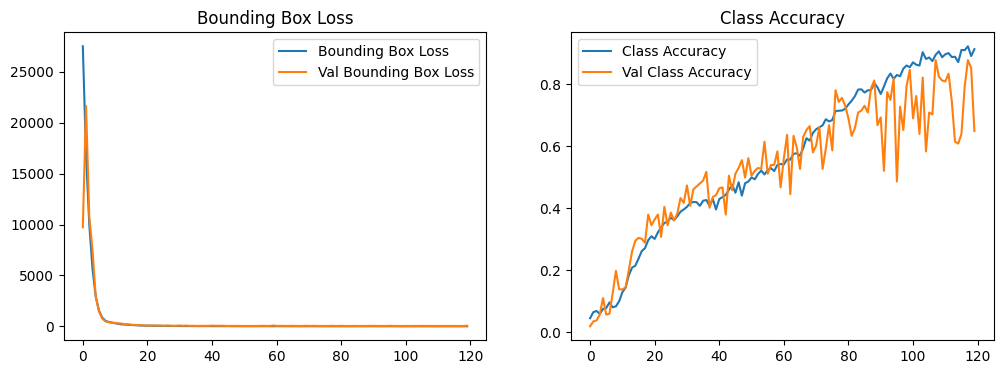

In [ ]:
# Menampilkan history pelatihan
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['bbox_output_loss'], label='Bounding Box Loss')
plt.plot(history.history['val_bbox_output_loss'], label='Val Bounding Box Loss')
plt.legend()
plt.title('Bounding Box Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['class_output_accuracy'], label='Class Accuracy')
plt.plot(history.history['val_class_output_accuracy'], label='Val Class Accuracy')
plt.legend()
plt.title('Class Accuracy')
plt.show()

10/10 [==============================] - 1s 65ms/step


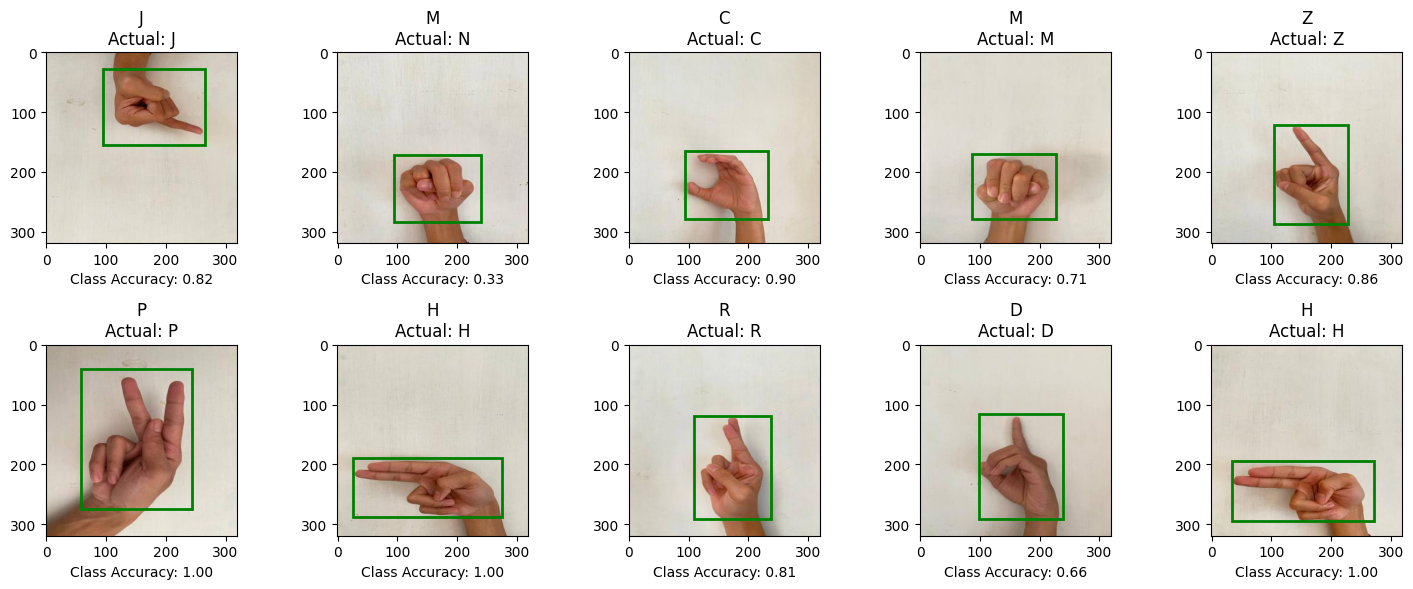

In [ ]:
# Fungsi untuk menampilkan gambar dengan bounding box dan nilai prediksi
def display_validation_results(X_val, y_bbox_val, y_class_val, classes_list, model, num_samples=10, samples_per_row=5):
    predictions = model.predict(X_val)
    bbox_predictions, class_predictions = predictions[0], predictions[1]

    num_rows = (num_samples + samples_per_row - 1) // samples_per_row  # Menghitung jumlah baris yang diperlukan
    plt.figure(figsize=(15, 3 * num_rows))  # Menyesuaikan ukuran gambar berdasarkan jumlah baris

    for i in range(num_samples):
        image = X_val[i]
        bbox_pred = bbox_predictions[i]
        class_pred = np.argmax(class_predictions[i])

        plt.subplot(num_rows, samples_per_row, i + 1)
        plt.imshow(cv2.cvtColor(image.astype('uint8'), cv2.COLOR_BGR2RGB))

        # Menggambar bounding box berdasarkan prediksi
        xmin, ymin, xmax, ymax = bbox_pred
        plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                          edgecolor='green', facecolor='none', linewidth=2))
        plt.title(f'{classes_list[class_pred]}\nActual: {classes_list[y_class_val[i]]}')

        # Menambahkan nilai akurasi di subplot
        plt.xlabel(f'Class Accuracy: {class_predictions[i][y_class_val[i]]:.2f}')

        # Memastikan tidak ada subplot yang kosong di akhir baris terakhir
        if (i + 1) % samples_per_row == 0:
            plt.tight_layout()

    plt.tight_layout()
    plt.show()

# Panggil fungsi ini setelah Anda melatih model dan ingin menampilkan hasil validasi
display_validation_results(X_val, y_bbox_val, y_class_val, classes_list, model, num_samples=10, samples_per_row=5)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Prediksi kelas pada data validasi
y_pred = model.predict(X_val)

# Mendapatkan kelas prediksi dengan nilai tertinggi
y_pred_class = np.argmax(y_pred[1], axis=1)

# Menampilkan confusion matrix
cm = confusion_matrix(y_class_val, y_pred_class)
print("Confusion Matrix:")
print(cm)

# Menampilkan classification report
cr = classification_report(y_class_val, y_pred_class, target_names=classes_list)
print("Classification Report:")
print(cr)


10/10 [==============================] - 1s 65ms/step
Confusion Matrix:
[[ 6  0  1  1  0  0  0  0  2  0  0  0  4  0  0  0  0  0  1  1  0  0  1  0
   0  0]
 [ 0  2  0  0  0  1  0  0  0  0  2  0  0  0  0  0  0  4  0  0  0  0  0  0
   0  0]
 [ 0  0 11  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0 16  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  2  0  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0
   0  0]
 [ 0  0  0  0  0 11  0  0  0  0  1  0  0  0  0  0  0  5  0  0  0  0  1  0
   0  0]
 [ 0  0  0  0  0  0 11  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  0  1 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  4  0  0  0  0 10  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  0  0  0  0  8  0  0  0  0  1  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  0  0  0  0  0  6  0  0  0  0  0  0  8  0  0  0  0  0  0
   0  1]
 [ 0  0  0  0  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Fungsi untuk memuat dan menampilkan gambar dengan prediksi bounding box
def validate_single_image(image_path, model, classes_list):
    # Memuat gambar dari path
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Konversi ke format RGB

    # Reshape gambar untuk model
    input_image = cv2.resize(image, (320, 320))  # Ubah sesuai dengan dimensi masukan model Anda
    input_image = np.expand_dims(input_image, axis=0)

    # Melakukan prediksi menggunakan model
    predictions = model.predict(input_image)
    bbox_predictions, class_predictions = predictions[0], predictions[1]

    # Mengambil hasil prediksi untuk gambar pertama
    bbox_pred = bbox_predictions[0]
    class_pred = np.argmax(class_predictions[0])

    # Menampilkan gambar dengan bounding box dan label prediksi
    plt.figure(figsize=(8, 6))
    plt.imshow(image_rgb)

    # Menggambar bounding box berdasarkan prediksi
    xmin, ymin, xmax, ymax = bbox_pred
    plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                      edgecolor='green', facecolor='none', linewidth=2))
    plt.title(f'Predicted Class: {classes_list[class_pred]}')
    plt.axis('off')
    plt.show()

# Contoh penggunaan
# Pastikan path gambar sesuai dengan lokasi gambar yang ingin Anda uji
image_path = 'path_to_your_image.jpg'  # Ganti dengan path gambar Anda
validate_single_image(image_path, model, classes_list)


error: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


1/1 [==============================] - 0s 426ms/step
class_pred: [23]
classes_list: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


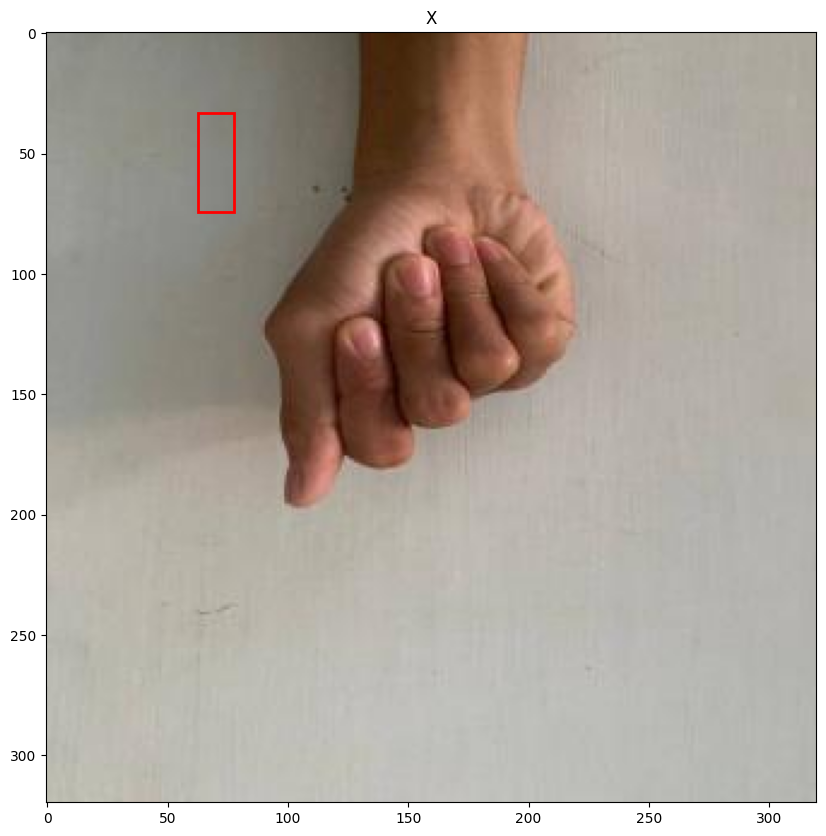

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import json

# Muat model yang telah dilatih
model_path = '/content/drive/MyDrive/Materi/jari/model_checkpoint.h5'
model = load_model(model_path)

# Muat daftar kelas dari file JSON
with open('/content/drive/MyDrive/jari/classes_list.json', 'r') as f:
    classes_list = json.load(f)

# Fungsi untuk memuat gambar uji
def load_test_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (320, 320))
    return image

# Fungsi untuk pra-pemrosesan gambar
def preprocess_image(image):
    image = image / 255.0
    image = np.expand_dims(image, axis=0)
    return image

# Fungsi untuk membuat prediksi
def make_predictions(model, image):
    bbox_pred, class_pred = model.predict(image)
    class_pred = np.argmax(class_pred, axis=-1)
    return bbox_pred, class_pred

# Fungsi untuk menampilkan hasil
def display_test_image(image_path, bbox_pred, class_pred, classes_list):
    # Debugging: Periksa prediksi kelas dan daftar kelas
    print(f"class_pred: {class_pred}")
    print(f"classes_list: {classes_list}")

    if class_pred[0] < len(classes_list):
        label = classes_list[class_pred[0]]
    else:
        label = "Unknown"

    image = cv2.imread(image_path)
    image = cv2.resize(image, (320, 320))
    bbox = bbox_pred[0]

    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.gca().add_patch(plt.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1],
                                      edgecolor='red', facecolor='none', linewidth=2))
    plt.title(label)
    plt.show()

# Path ke gambar uji
test_image_path = '/content/drive/MyDrive/jari/jari/images/photo1719277181-10-_jpeg.rf.7dc2707ae46061a2eeae12b97342cb03.jpg'

# Muat dan pra-pemroses gambar uji
test_image = load_test_image(test_image_path)
preprocessed_image = preprocess_image(test_image)

# Buat prediksi
bbox_pred, class_pred = make_predictions(model, preprocessed_image)

# Tampilkan hasil
display_test_image(test_image_path, bbox_pred, class_pred, classes_list)


In [ ]:
from tensorflow.keras.models import load_model

# Path ke model yang telah dilatih (.h5)
model_path = '/content/drive/MyDrive/Materi/jari/model_checkpoint.h5'
model = load_model(model_path)

In [ ]:
# Mendapatkan jumlah kelas dari model
num_classes = model.layers[-1].output_shape[-1]
print(f"Jumlah kelas dalam model: {num_classes}")


Jumlah kelas dalam model: 26


In [ ]:
# Pastikan bahwa output layer adalah layer Dense dengan aktivasi softmax
output_layer = model.layers[-1]

# Ambil bobot (weights) dan bias dari output layer
weights, bias = output_layer.get_weights()

# Jika model menggunakan softmax untuk klasifikasi multikelas
if output_layer.activation == 'softmax':
    # Ambil daftar kelas dari bobot
    classes_list = list(output_layer.get_weights()[1])

# Cetak semua kelas yang ada dalam model
print("Kelas yang ada dalam model:")
for i, class_name in enumerate(classes_list):
    print(f"Kelas {i + 1}: {class_name}")


Kelas yang ada dalam model:
Kelas 1: A
Kelas 2: B
Kelas 3: C
Kelas 4: D
Kelas 5: E
Kelas 6: F
